In [1]:
"""
Visualize signal data. Verify DA would work or not.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

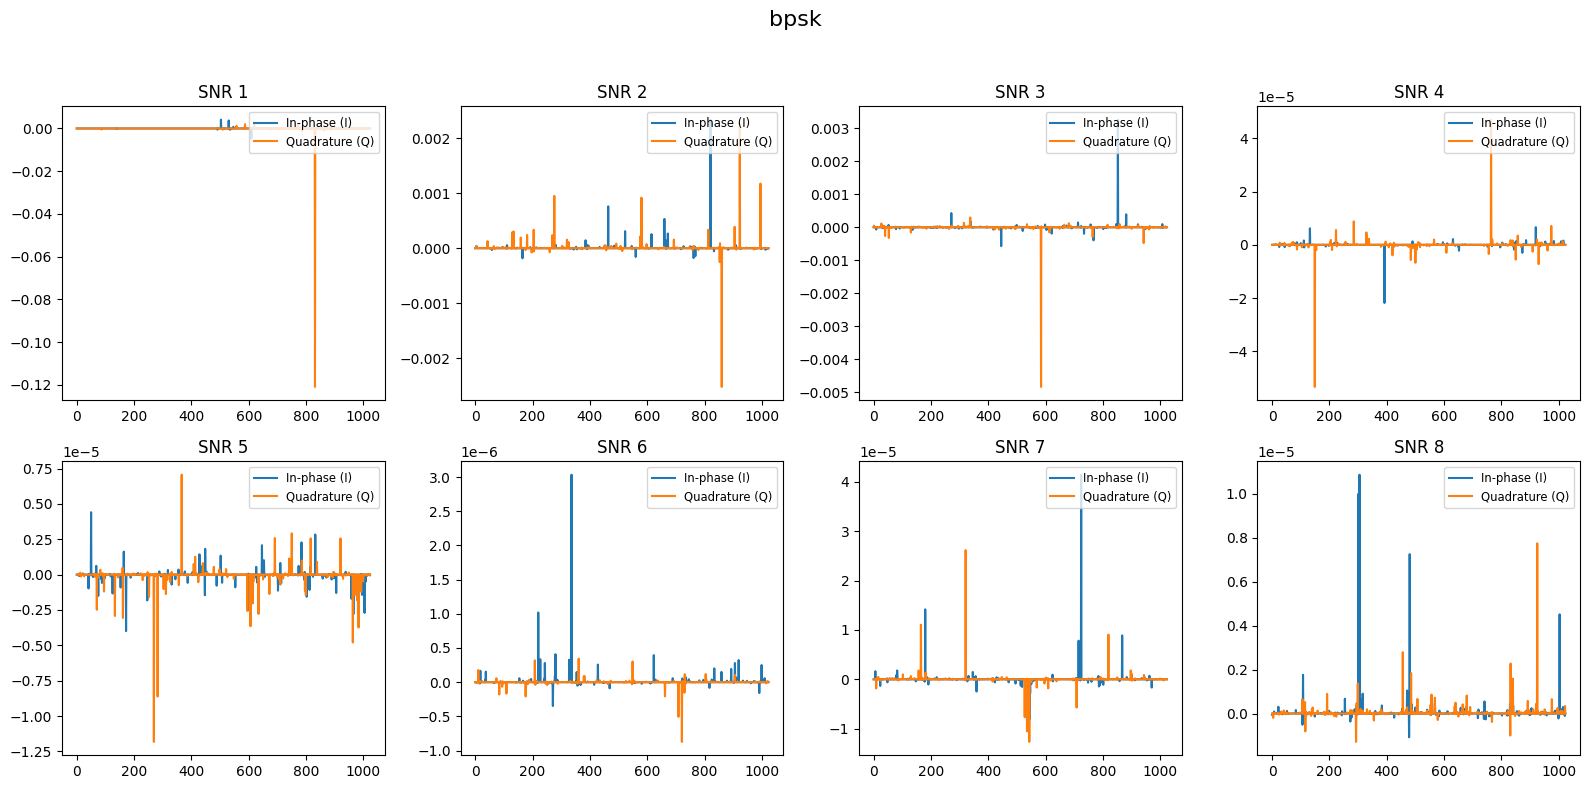

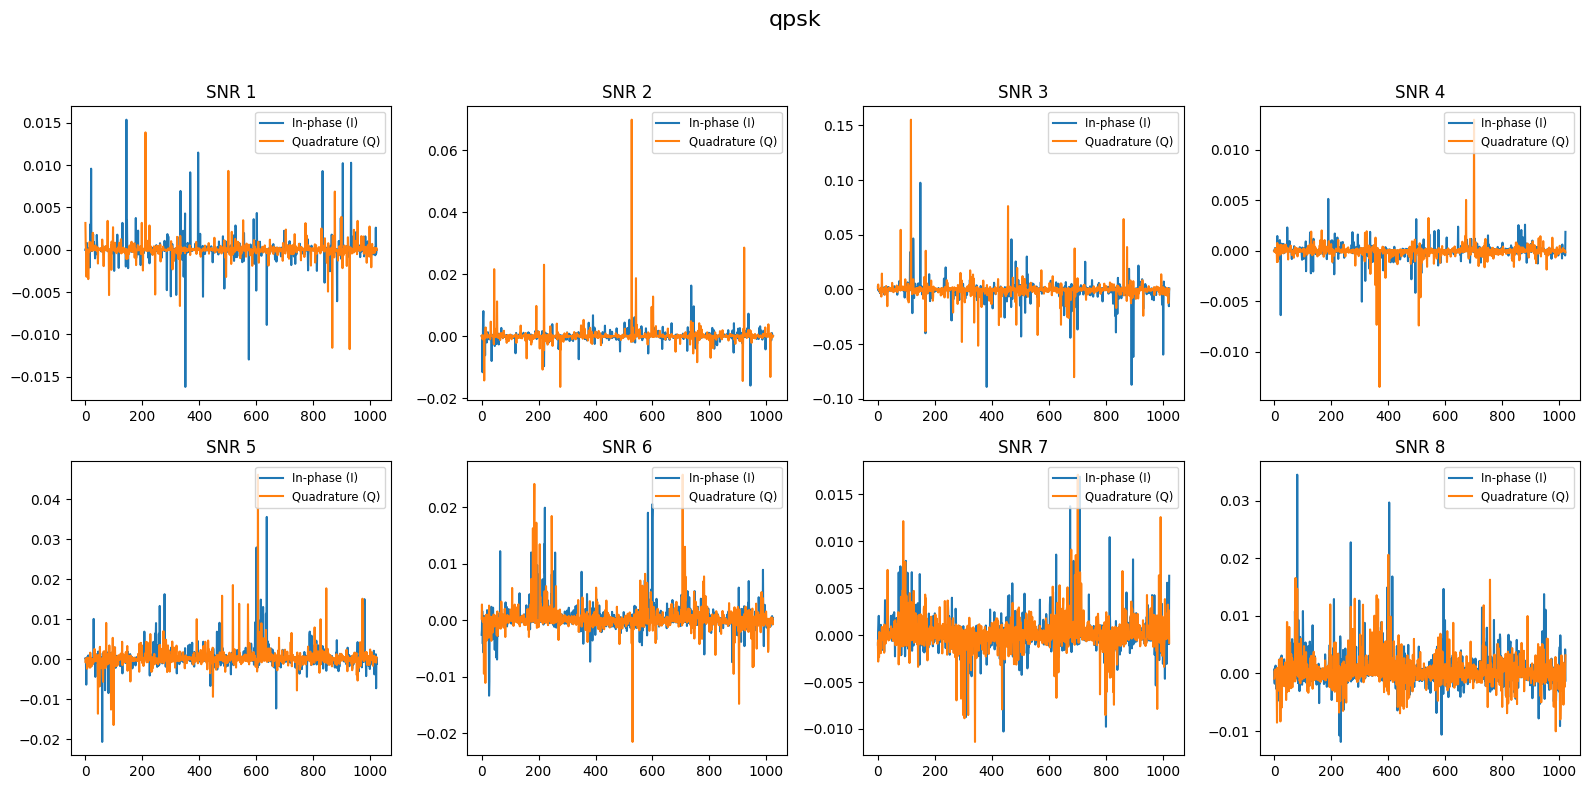

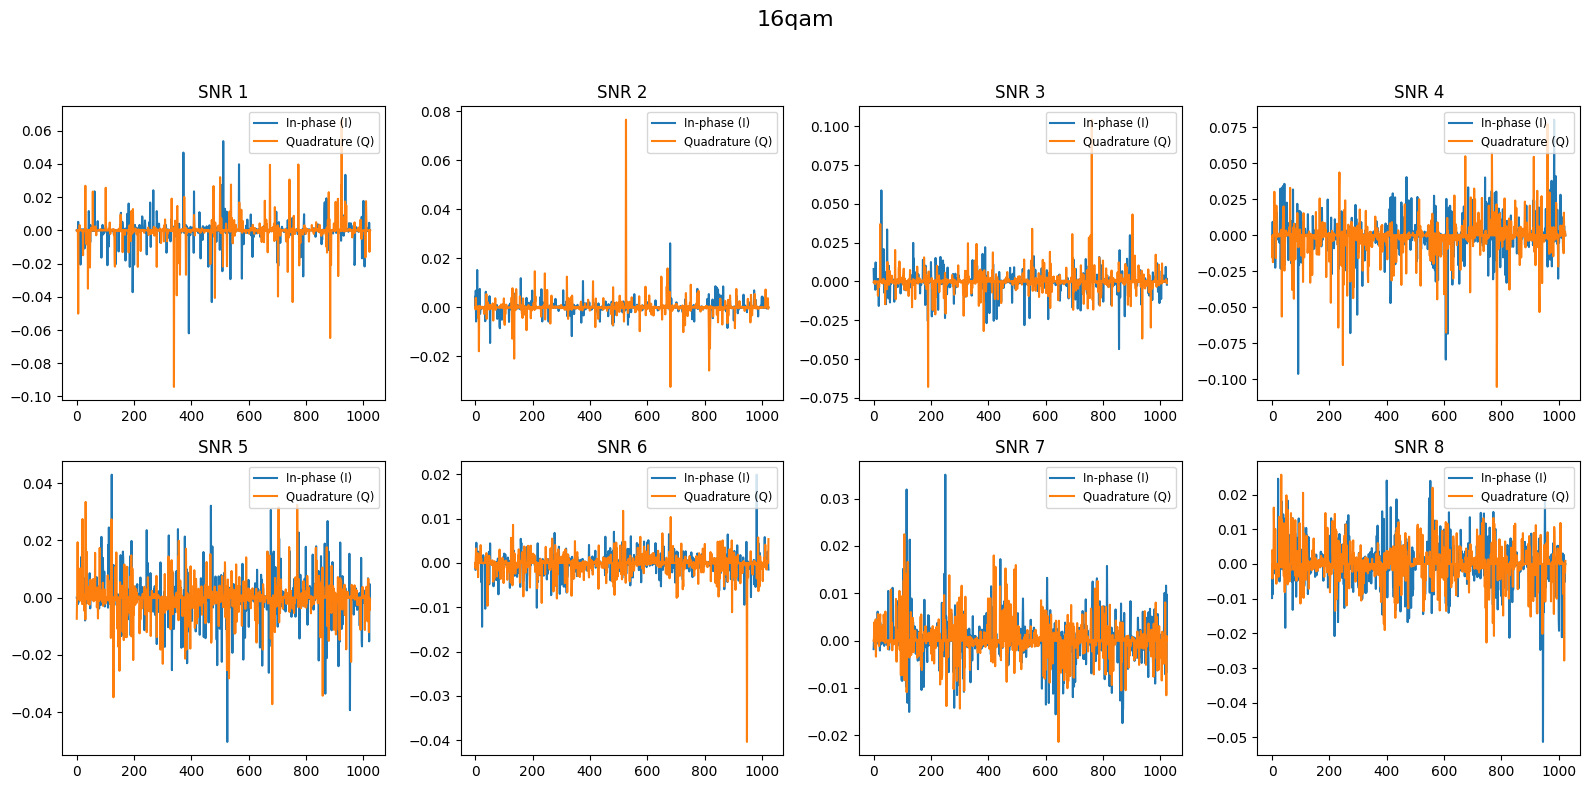

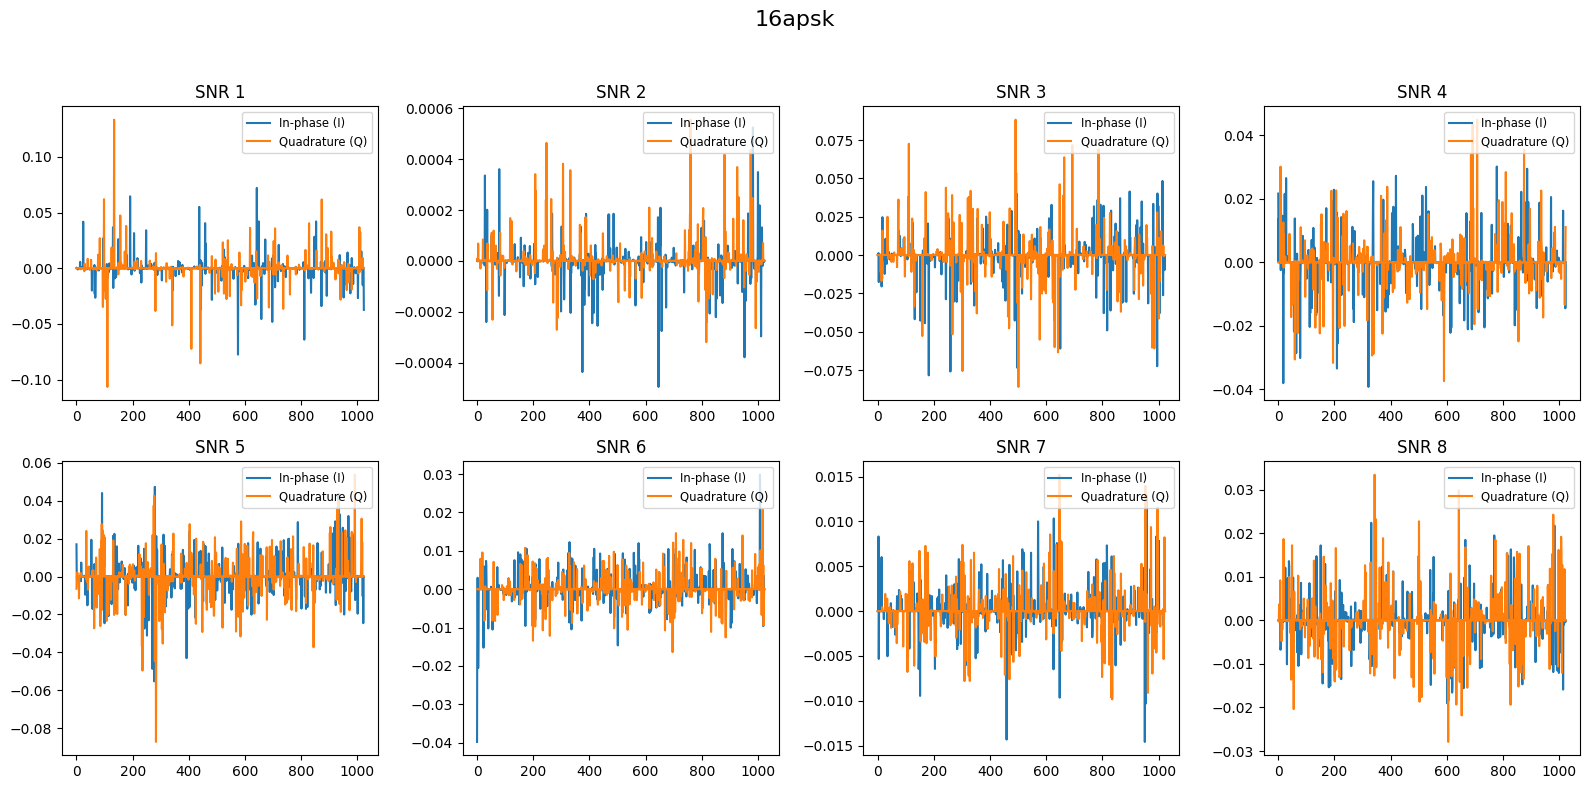

In [2]:
# Plot fkn raw OTA signal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "16apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/ota_X.npy")
Y = np.load(file_path + "/ota_Y.npy")

offset = 0
for i in range(len(class_subset)):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"{class_subset[i]}", fontsize=16)
    
    for j in range(8):
        #print(f"offset: {offset}")
        frame = X[offset]

        ax = axs[j // 4, j % 4]
        ax.plot(frame[0], label='In-phase (I)')
        ax.plot(frame[1], label='Quadrature (Q)')
        ax.legend(loc='upper right', fontsize='small')
        ax.set_title(f'SNR {j+1}')

        offset += 4096 + 50
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Unique SNR levels: [10 12 14 16 18 20 22 24]
Subsampled X shape: (4000, 2, 1024)
Subsampled Y shape: (4000, 2)


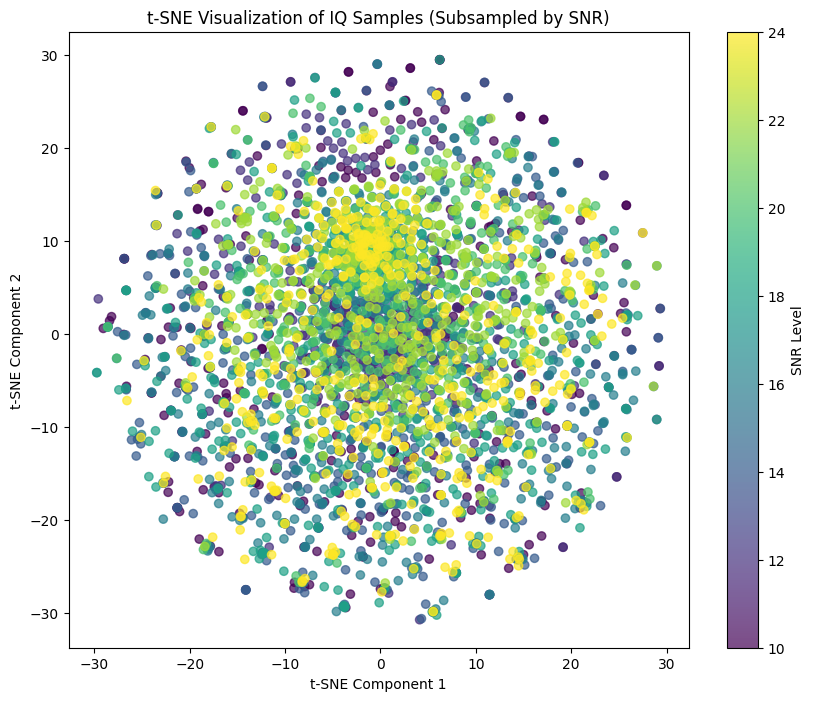

In [3]:
# tsne of ota by SNR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume X and Y are already loaded and have shapes:
#   X: (131072, 2, 1024)
#   Y: (131072, 2) where Y[:, 1] is the SNR value

# Set the number of samples you want per SNR level
samples_per_snr = 500

# Get the unique SNR values from the data
unique_snrs = np.unique(Y[:, 1])
print("Unique SNR levels:", unique_snrs)

selected_indices = []

# Loop over each SNR level and randomly choose indices
for snr in unique_snrs:
    # Get indices where the SNR matches
    indices = np.where(Y[:, 1] == snr)[0]
    if len(indices) > samples_per_snr:
        chosen = np.random.choice(indices, samples_per_snr, replace=False)
    else:
        chosen = indices  # if fewer than samples_per_snr, take them all
    selected_indices.extend(chosen)

# Convert to NumPy array (if not already)
selected_indices = np.array(selected_indices)

# Create the subsampled dataset
X_sub = X[selected_indices]
Y_sub = Y[selected_indices]

print("Subsampled X shape:", X_sub.shape)
print("Subsampled Y shape:", Y_sub.shape)

# Flatten each IQ sample from shape (2, 1024) to (2048,)
X_sub_flat = X_sub.reshape(X_sub.shape[0], -1)

# Run t-SNE on the flattened data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sub_flat)

# Use SNR labels from Y_sub (assume they're in the second column)
snr_labels = Y_sub[:, 1]

# Plot the t-SNE result with SNR as color
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=snr_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of IQ Samples (Subsampled by SNR)")
cbar = plt.colorbar(scatter)
cbar.set_label("SNR Level")
plt.show()


Unique constellation types: [0 1 2 3]
Subsampled X shape: (2000, 2, 1024)
Subsampled Y shape: (2000, 2)


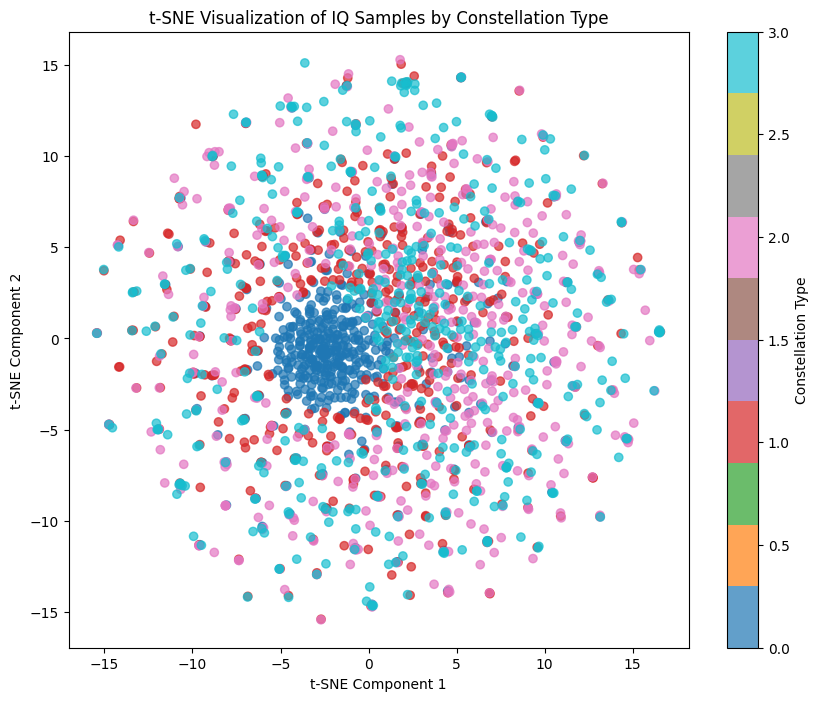

In [4]:
# tsne of ota by constellation type

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume X and Y are already loaded, with shapes:
#   X: (131072, 2, 1024)
#   Y: (131072, 2) where Y[:, 0] holds the constellation label.

# Set the number of samples you want per constellation
samples_per_constellation = 500

# Get the unique constellation types from Y[:, 0]
unique_constellations = np.unique(Y[:, 0])
print("Unique constellation types:", unique_constellations)

selected_indices = []

# Loop over each constellation and randomly choose indices
for constellation in unique_constellations:
    indices = np.where(Y[:, 0] == constellation)[0]
    if len(indices) > samples_per_constellation:
        chosen = np.random.choice(indices, samples_per_constellation, replace=False)
    else:
        chosen = indices  # if fewer than desired, take them all
    selected_indices.extend(chosen)

selected_indices = np.array(selected_indices)

# Create the subsampled dataset
X_sub = X[selected_indices]
Y_sub = Y[selected_indices]

print("Subsampled X shape:", X_sub.shape)
print("Subsampled Y shape:", Y_sub.shape)

# Flatten each IQ sample from shape (2, 1024) to (2048,)
X_sub_flat = X_sub.reshape(X_sub.shape[0], -1)

# Run t-SNE on the flattened data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sub_flat)

# Use constellation labels from Y_sub (assume they're in the first column)
constellation_labels = Y_sub[:, 0]

# Plot the t-SNE result with each constellation type as a different color
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                      c=constellation_labels, cmap='tab10', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of IQ Samples by Constellation Type")
cbar = plt.colorbar(scatter)
cbar.set_label("Constellation Type")
plt.show()


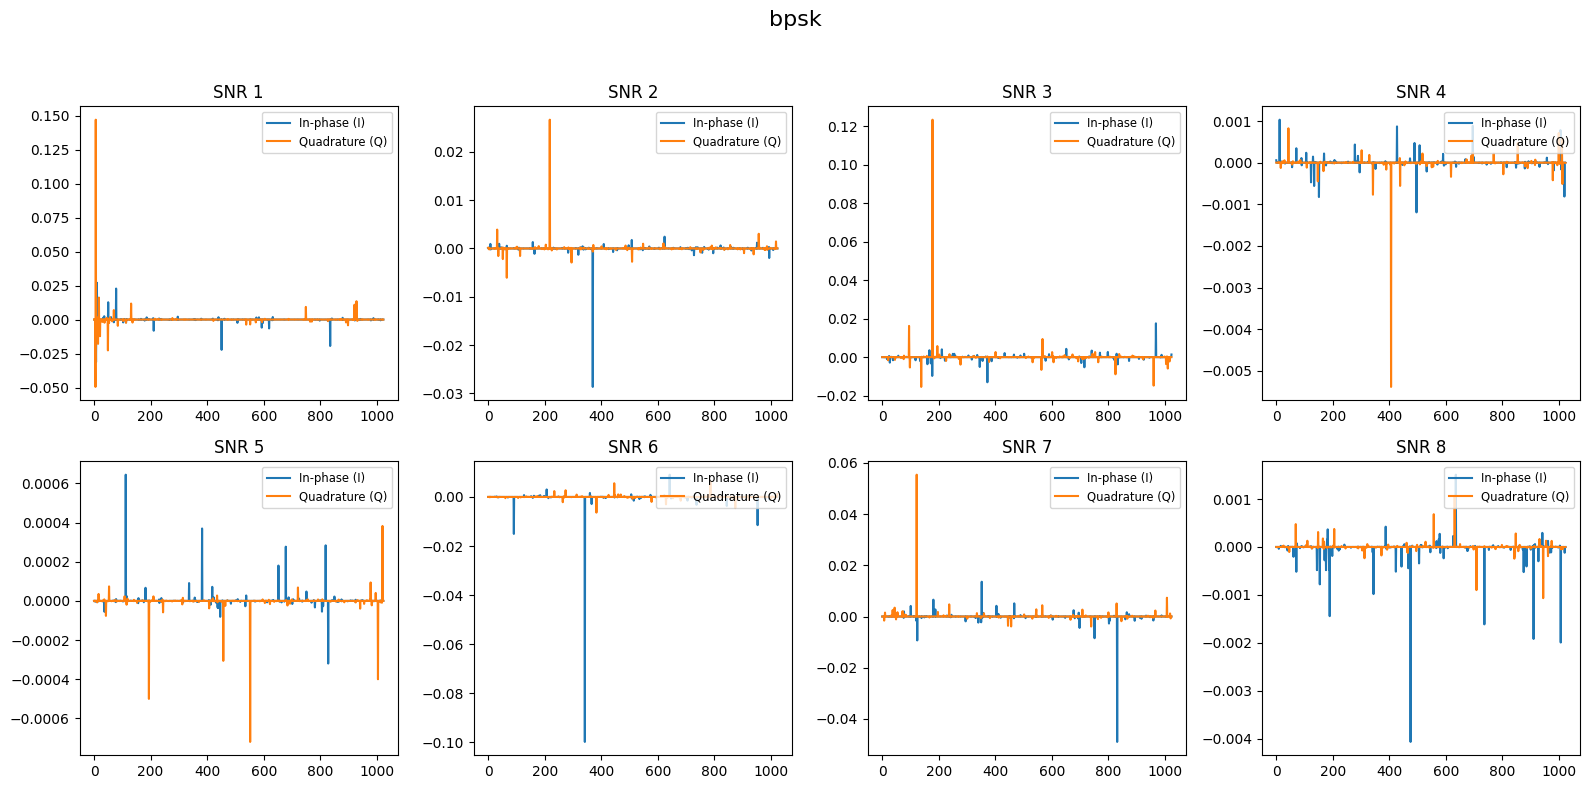

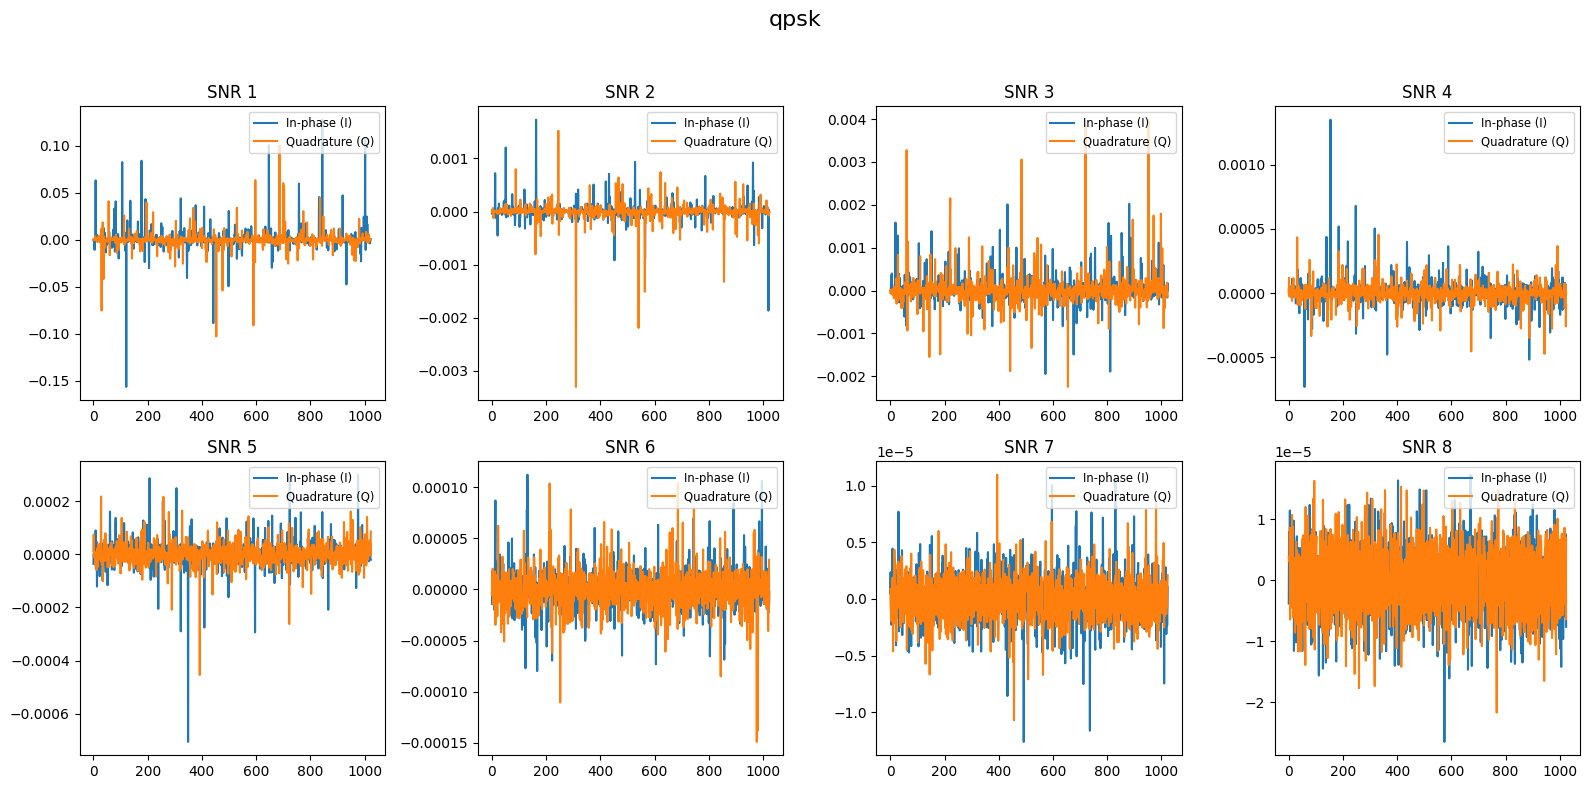

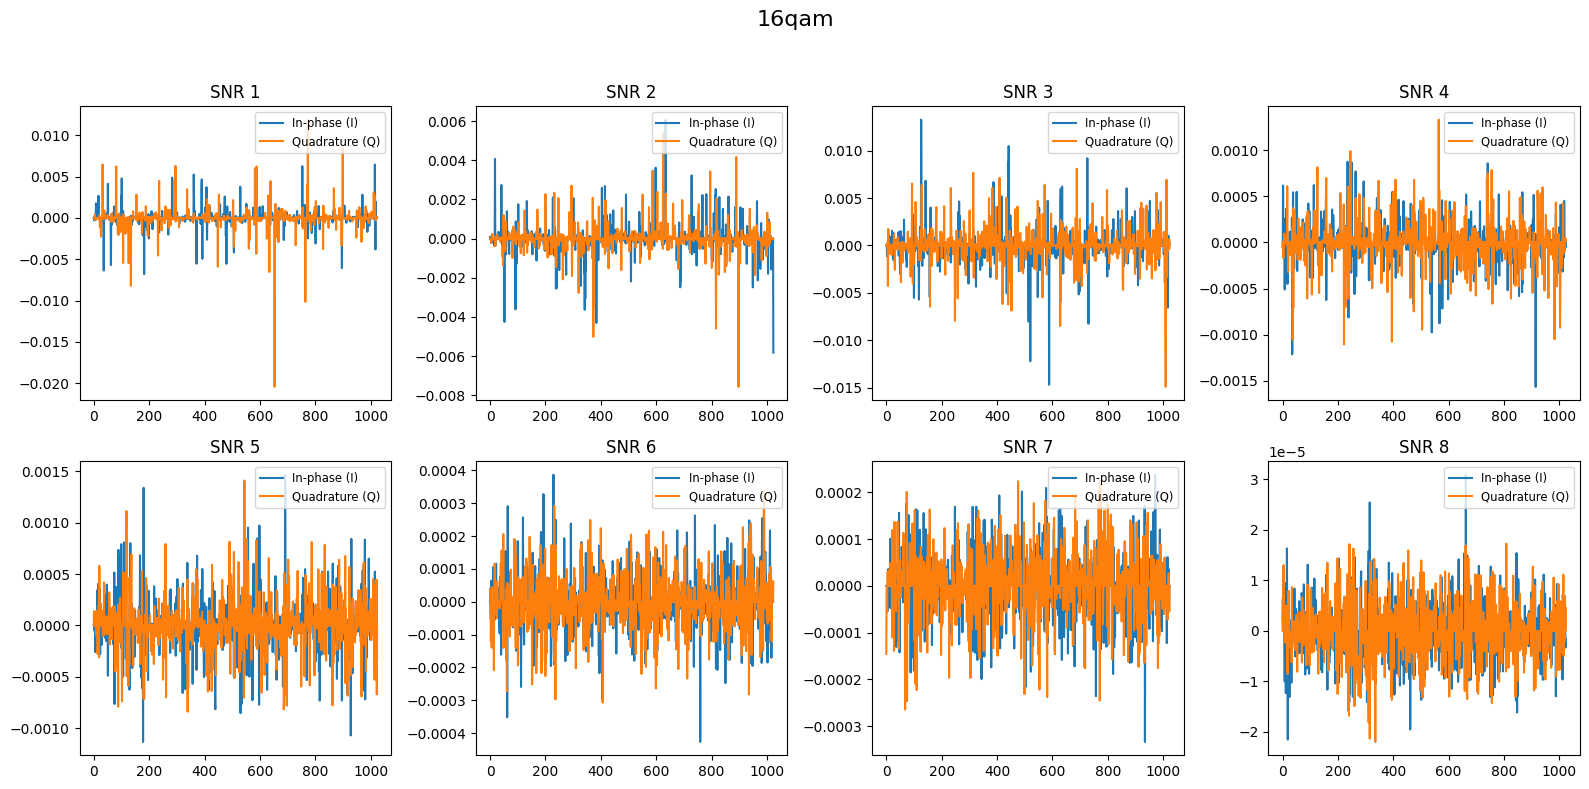

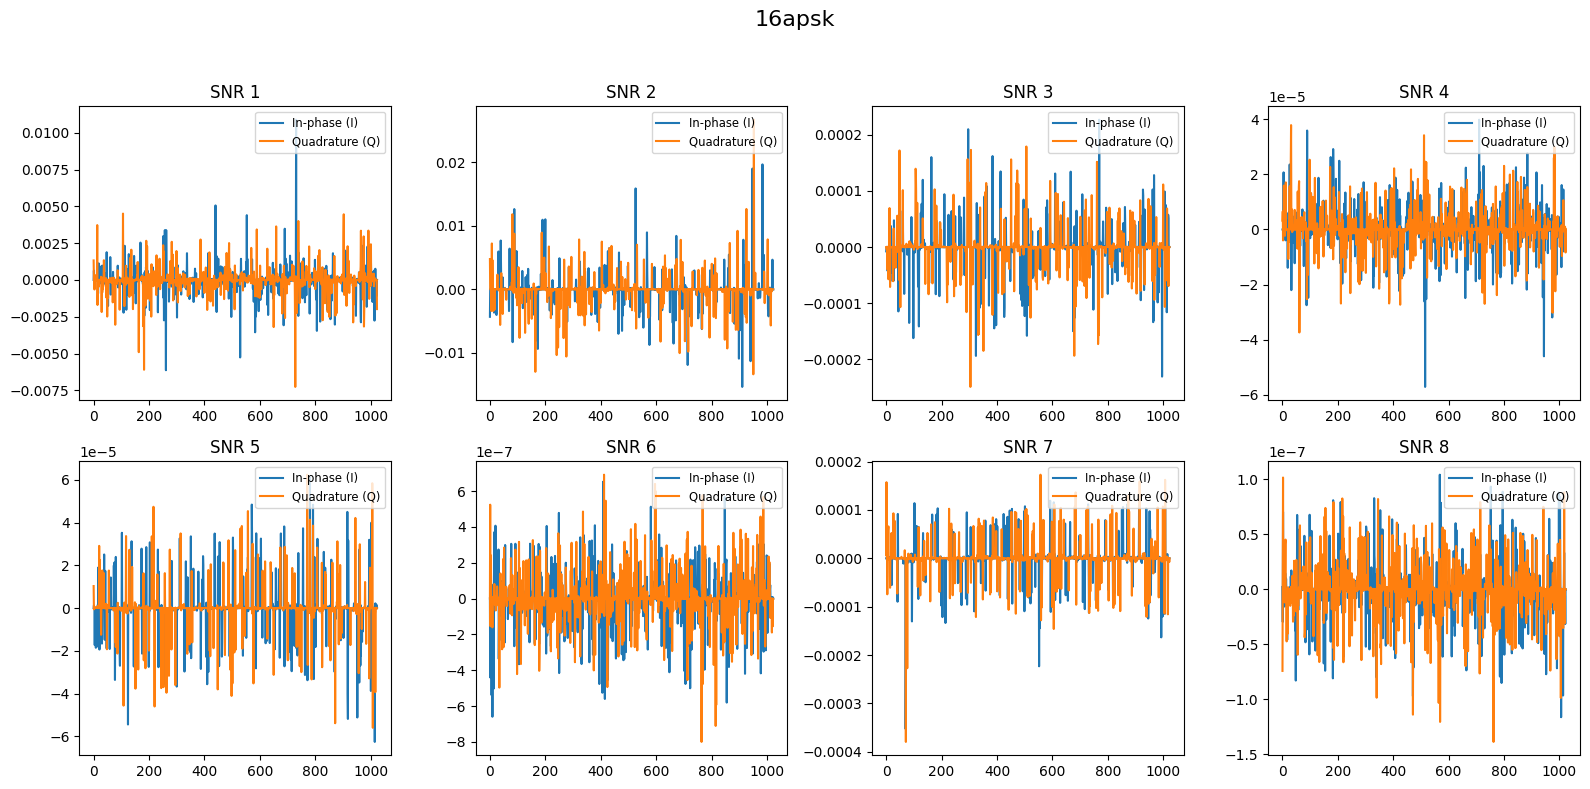

In [5]:
# Plot fkn raw sim signal 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "16apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/sim_X.npy")
Y = np.load(file_path + "/sim_Y.npy")

offset = 0
for i in range(len(class_subset)):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"{class_subset[i]}", fontsize=16)
    
    for j in range(8):
        #print(f"offset: {offset}")
        frame = X[offset]

        ax = axs[j // 4, j % 4]
        ax.plot(frame[0], label='In-phase (I)')
        ax.plot(frame[1], label='Quadrature (Q)')
        ax.legend(loc='upper right', fontsize='small')
        ax.set_title(f'SNR {j+1}')

        offset += 4096 + 50
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Unique SNR levels: [110 112 114 116 118 120 122 124]
Subsampled X shape: (4000, 2, 1024)
Subsampled Y shape: (4000, 2)


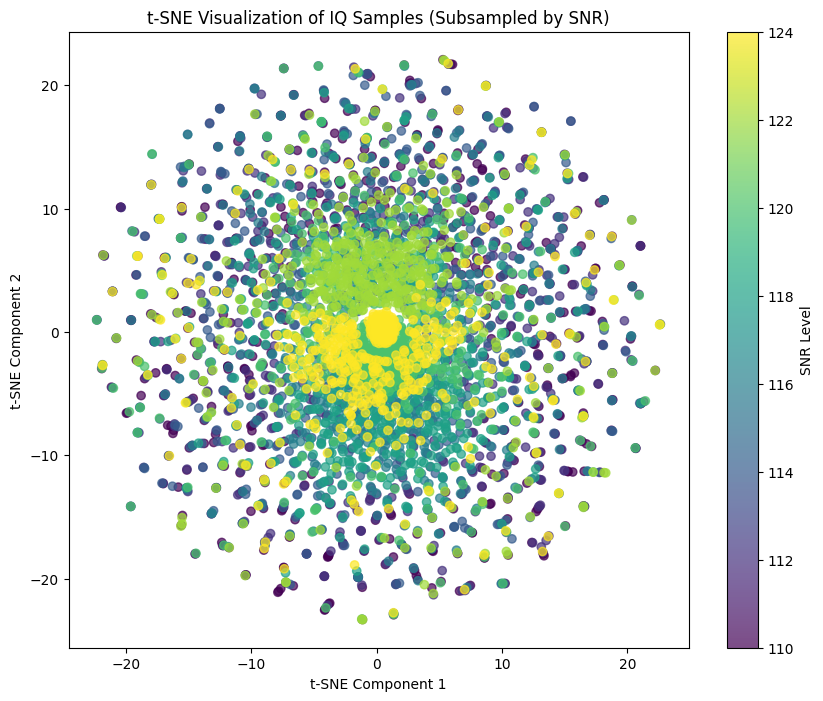

In [6]:
# tsne of sim by SNR

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume X and Y are already loaded and have shapes:
#   X: (131072, 2, 1024)
#   Y: (131072, 2) where Y[:, 1] is the SNR value

# Set the number of samples you want per SNR level
samples_per_snr = 500

# Get the unique SNR values from the data
unique_snrs = np.unique(Y[:, 1])
print("Unique SNR levels:", unique_snrs)

selected_indices = []

# Loop over each SNR level and randomly choose indices
for snr in unique_snrs:
    # Get indices where the SNR matches
    indices = np.where(Y[:, 1] == snr)[0]
    if len(indices) > samples_per_snr:
        chosen = np.random.choice(indices, samples_per_snr, replace=False)
    else:
        chosen = indices  # if fewer than samples_per_snr, take them all
    selected_indices.extend(chosen)

# Convert to NumPy array (if not already)
selected_indices = np.array(selected_indices)

# Create the subsampled dataset
X_sub = X[selected_indices]
Y_sub = Y[selected_indices]

print("Subsampled X shape:", X_sub.shape)
print("Subsampled Y shape:", Y_sub.shape)

# Flatten each IQ sample from shape (2, 1024) to (2048,)
X_sub_flat = X_sub.reshape(X_sub.shape[0], -1)

# Run t-SNE on the flattened data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sub_flat)

# Use SNR labels from Y_sub (assume they're in the second column)
snr_labels = Y_sub[:, 1]

# Plot the t-SNE result with SNR as color
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=snr_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of IQ Samples (Subsampled by SNR)")
cbar = plt.colorbar(scatter)
cbar.set_label("SNR Level")
plt.show()


Unique constellation types: [0 1 2 3]
Subsampled X shape: (2000, 2, 1024)
Subsampled Y shape: (2000, 2)


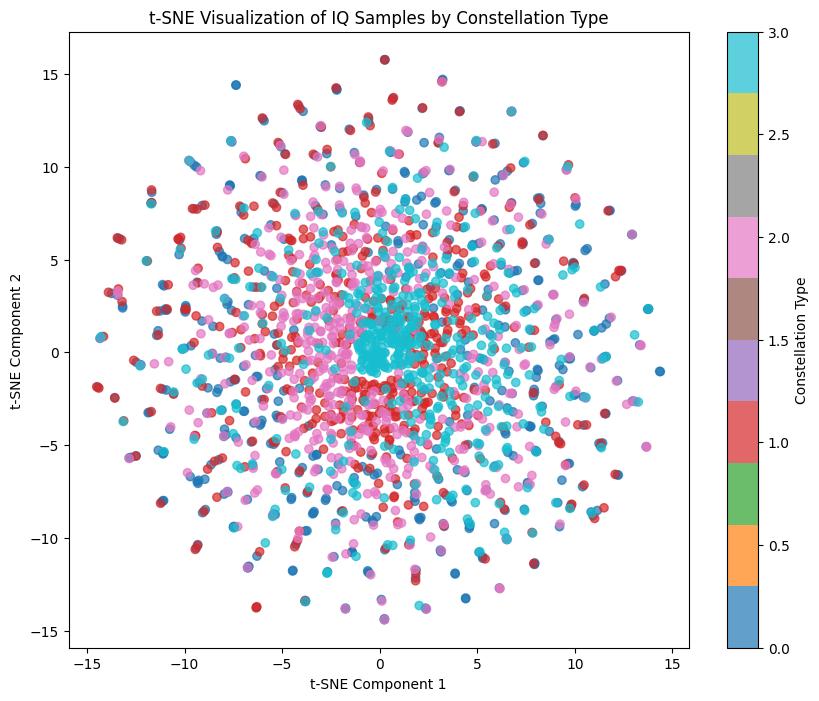

In [7]:
# tsne of sim by constellation type

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume X and Y are already loaded, with shapes:
#   X: (131072, 2, 1024)
#   Y: (131072, 2) where Y[:, 0] holds the constellation label.

# Set the number of samples you want per constellation
samples_per_constellation = 500

# Get the unique constellation types from Y[:, 0]
unique_constellations = np.unique(Y[:, 0])
print("Unique constellation types:", unique_constellations)

selected_indices = []

# Loop over each constellation and randomly choose indices
for constellation in unique_constellations:
    indices = np.where(Y[:, 0] == constellation)[0]
    if len(indices) > samples_per_constellation:
        chosen = np.random.choice(indices, samples_per_constellation, replace=False)
    else:
        chosen = indices  # if fewer than desired, take them all
    selected_indices.extend(chosen)

selected_indices = np.array(selected_indices)

# Create the subsampled dataset
X_sub = X[selected_indices]
Y_sub = Y[selected_indices]

print("Subsampled X shape:", X_sub.shape)
print("Subsampled Y shape:", Y_sub.shape)

# Flatten each IQ sample from shape (2, 1024) to (2048,)
X_sub_flat = X_sub.reshape(X_sub.shape[0], -1)

# Run t-SNE on the flattened data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sub_flat)

# Use constellation labels from Y_sub (assume they're in the first column)
constellation_labels = Y_sub[:, 0]

# Plot the t-SNE result with each constellation type as a different color
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                      c=constellation_labels, cmap='tab10', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of IQ Samples by Constellation Type")
cbar = plt.colorbar(scatter)
cbar.set_label("Constellation Type")
plt.show()
